## 4차 과제 - Hyperparameter Tuning을 해보자
- 주제: 하이퍼파라미터 튜닝 기법 학습
- 데이터: The History of Baseball(Pitching Data) https://www.kaggle.com/datasets/seanlahman/the-history-of-baseball?select=pitching.csv
- 사용 라이브러리: pandas, numpy, matplotlib, sklearn, imblearn, bayes_opt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 1. EDA, 전처리

1.1 분석을 위해 사용될 라이브러리들을 import 하세요.

numpy, pandas, matplotlib, SMOTE, train_test_split, RandomForestClassifier, RandomizedSearchCV, GridSearchCV, BayesianOptimization, accuracy_score

In [1]:
pip install bayesian-optimization

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from bayes_opt import BayesianOptimization
from sklearn.metrics import accuracy_score

1.2 데이터를 불러오고 info()를 통해 데이터를 살펴보세요.

In [4]:
df = pd.read_csv("/content/gdrive/MyDrive/DAT/pitching.csv", encoding="cp949")
df.head(10)

,player_id,year,stint,team_id,league_id,w,l,g,gs,cg,...,ibb,wp,hbp,bk,bfp,gf,r,sh,sf,g_idp
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,...,NaN,NaN,NaN,0,NaN,NaN,42,NaN,NaN,NaN
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,...,NaN,NaN,NaN,0,NaN,NaN,292,NaN,NaN,NaN
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,...,NaN,NaN,NaN,0,NaN,NaN,9,NaN,NaN,NaN
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,...,NaN,NaN,NaN,0,NaN,NaN,257,NaN,NaN,NaN
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,...,NaN,NaN,NaN,0,NaN,NaN,21,NaN,NaN,NaN
5,flowedi01,1871,1,TRO,NaN,0,0,1,0,0,...,NaN,NaN,NaN,0,NaN,NaN,0,NaN,NaN,NaN
6,mackde01,1871,1,RC1,NaN,0,1,3,1,1,...,NaN,NaN,NaN,0,NaN,NaN,30,NaN,NaN,NaN
7,mathebo01,1871,1,FW1,NaN,6,11,19,19,19,...,NaN,NaN,NaN,2,NaN,NaN,243,NaN,NaN,NaN
8,mcbridi01,1871,1,PH1,NaN,18,5,25,25,25,...,NaN,NaN,NaN,0,NaN,NaN,223,NaN,NaN,NaN
9,mcmuljo01,1871,1,TRO,NaN,12,15,29,29,28,...,NaN,NaN,NaN,0,NaN,NaN,362,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44139 entries, 0 to 44138
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   player_id  44139 non-null  object 
 1   year       44139 non-null  int64  
 2   stint      44139 non-null  int64  
 3   team_id    44139 non-null  object 
 4   league_id  44008 non-null  object 
 5   w          44139 non-null  int64  
 6   l          44139 non-null  int64  
 7   g          44139 non-null  int64  
 8   gs         44139 non-null  int64  
 9   cg         44139 non-null  int64  
 10  sho        44139 non-null  int64  
 11  sv         44139 non-null  int64  
 12  ipouts     44138 non-null  float64
 13  h          44139 non-null  int64  
 14  er         44139 non-null  int64  
 15  hr         44139 non-null  int64  
 16  bb         44139 non-null  int64  
 17  so         44139 non-null  int64  
 18  baopp      42614 non-null  float64
 19  era        44049 non-null  float64
 20  ibb   

1.3 null 값이 있는 컬럼은 모두 삭제하겠습니다(원래는 다른 처리를 해야 하지만 컬럼 수는 충분하니까..ㅎㅎ 야구 잘 몰라서 그런 거 아닙니다.).

In [6]:
df = df.dropna(axis=1, how='any')
df.head(5)

,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,bechtge01,1871,1,PH1,1,2,3,3,2,0,0,43,23,0,11,1,0,42
1,brainas01,1871,1,WS3,12,15,30,30,30,0,0,361,132,4,37,13,0,292
2,fergubo01,1871,1,NY2,0,0,1,0,0,0,0,8,3,0,0,0,0,9
3,fishech01,1871,1,RC1,4,16,24,24,22,1,0,295,103,3,31,15,0,257
4,fleetfr01,1871,1,NY2,0,1,1,1,1,0,0,20,10,0,3,0,0,21


1.4 연도 별로 몇개의 데이터가 있는 지 확인 후 데이터가 얼마 없는 과거 데이터는 삭제하겠습니다. 이를 위해 연도 별 데이터 수를 계산하고 line plot으로 그리세요.

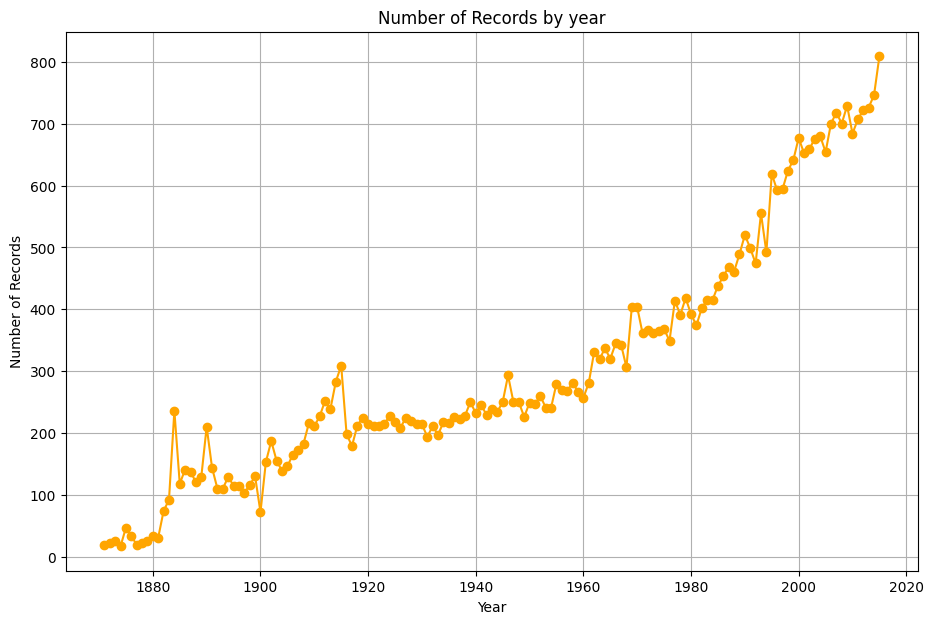

In [7]:
yearly_counts = df['year'].value_counts().sort_index()

plt.figure(figsize=(11, 7))
plt.plot(yearly_counts.index, yearly_counts.values, marker='o', linestyle='-', color='orange')
plt.title('Number of Records by year')
plt.xlabel('Year')
plt.ylabel('Number of Records')
plt.grid(True)
plt.show()

1.5 보다 최신 분석을 위해 1980년 이후의 데이터만 남기고 몇개의 데이터가 남았는지 확인하세요.

In [8]:
new_df = df[df['year'] >= 1980]
new_df

,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
22982,aasedo01,1980,1,CAL,8,13,40,21,5,1,2,193,79,13,66,74,1,83
22983,abbotgl01,1980,1,SEA,12,12,31,31,7,2,0,228,98,27,49,78,1,110
22984,alexado01,1980,1,ATL,14,11,35,35,7,1,0,227,108,20,74,114,0,120
22985,allarbr01,1980,1,TEX,0,1,5,2,0,0,0,13,9,0,10,10,0,13
22986,allenne01,1980,1,NYN,7,10,59,0,0,0,22,87,40,7,40,79,1,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44134,youngch03,2015,1,KCA,11,6,34,18,0,0,0,91,42,16,43,83,0,44
44135,zieglbr01,2015,1,ARI,0,3,66,0,0,0,30,48,14,3,17,36,0,17
44136,zimmejo02,2015,1,WAS,13,10,33,33,0,0,0,204,82,24,39,164,1,89
44137,zitoba01,2015,1,OAK,0,0,3,2,0,0,0,12,8,4,6,2,0,8


1.6 reset_index()를 통해 재배열하세요.

In [9]:
new_df = new_df.reset_index(drop=True)
new_df

,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,aasedo01,1980,1,CAL,8,13,40,21,5,1,2,193,79,13,66,74,1,83
1,abbotgl01,1980,1,SEA,12,12,31,31,7,2,0,228,98,27,49,78,1,110
2,alexado01,1980,1,ATL,14,11,35,35,7,1,0,227,108,20,74,114,0,120
3,allarbr01,1980,1,TEX,0,1,5,2,0,0,0,13,9,0,10,10,0,13
4,allenne01,1980,1,NYN,7,10,59,0,0,0,22,87,40,7,40,79,1,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21152,youngch03,2015,1,KCA,11,6,34,18,0,0,0,91,42,16,43,83,0,44
21153,zieglbr01,2015,1,ARI,0,3,66,0,0,0,30,48,14,3,17,36,0,17
21154,zimmejo02,2015,1,WAS,13,10,33,33,0,0,0,204,82,24,39,164,1,89
21155,zitoba01,2015,1,OAK,0,0,3,2,0,0,0,12,8,4,6,2,0,8


1.7 투수의 승리 수를 예측해보겠습니다. w 컬럼의 value를 확인해보세요.

In [10]:
new_df['w'].value_counts()

w
0     5854
1     3197
2     2356
3     1744
4     1453
5     1114
6      878
7      730
9      560
8      557
10     450
11     434
12     384
13     317
14     287
15     242
16     193
17     125
18     102
19      61
20      53
21      32
22      17
24       8
23       7
25       1
27       1
Name: count, dtype: int64

1.8 0승 투수(출전하지 않은 경우도 존재)가 많으므로 승리 수가 0인 데이터는 삭제하겠습니다.

In [11]:
new_df = new_df[new_df['w'] != 0]
new_df.shape[0]

15303

1.9 Regression이 아닌 Classification으로 분석해보겠습니다. 이를 위해 10을 기준으로 w를 10승 이상이면 1, 10승 미만이면 0인 Binary 형태로 변환하세요.

In [12]:
new_df['w'] = new_df['w'].apply(lambda x: 1 if x >= 10 else 0)
new_df

<ipython-input-12-3329f725439e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['w'] = new_df['w'].apply(lambda x: 1 if x >= 10 else 0)


,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,aasedo01,1980,1,CAL,0,13,40,21,5,1,2,193,79,13,66,74,1,83
1,abbotgl01,1980,1,SEA,1,12,31,31,7,2,0,228,98,27,49,78,1,110
2,alexado01,1980,1,ATL,1,11,35,35,7,1,0,227,108,20,74,114,0,120
4,allenne01,1980,1,NYN,0,10,59,0,0,0,22,87,40,7,40,79,1,43
6,andujjo01,1980,1,HOU,0,8,35,14,0,0,2,132,53,8,43,75,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,wrighmi01,2015,1,BAL,0,5,12,9,0,0,0,52,30,9,18,26,0,30
21148,wrighst01,2015,1,BOS,0,4,16,9,0,0,0,67,33,12,27,52,0,38
21151,yateski01,2015,1,TBA,0,0,20,0,0,0,0,23,18,10,7,21,0,18
21152,youngch03,2015,1,KCA,1,6,34,18,0,0,0,91,42,16,43,83,0,44


1.10 value_counts()를 통해 잘 나눠졌는지 확인해보세요.

In [13]:
new_df['w'].value_counts()

w
0    12589
1     2714
Name: count, dtype: int64

1.11 종속 변수의 밸런스가 맞지 않는 것으로 확인됩니다. 이를 해결하기 위해 Under Sampling 혹은 Over Sampling 기법을 사용할 수 있는데 Under Sampling의 경우 데이터가 많지 않는 상황에서 사라지는 데이터가 과도하게 많으므로 Over Sampling 기법 중 SMOTE 기법을 사용해보겠습니다. 사용하기 전에 player_id, year, team_id 컬럼은 지우고 가겠습니다.

In [14]:
new_df = new_df.drop(['player_id', 'year', 'team_id'], axis=1)
new_df

,stint,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,1,0,13,40,21,5,1,2,193,79,13,66,74,1,83
1,1,1,12,31,31,7,2,0,228,98,27,49,78,1,110
2,1,1,11,35,35,7,1,0,227,108,20,74,114,0,120
4,1,0,10,59,0,0,0,22,87,40,7,40,79,1,43
6,1,0,8,35,14,0,0,2,132,53,8,43,75,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,1,0,5,12,9,0,0,0,52,30,9,18,26,0,30
21148,1,0,4,16,9,0,0,0,67,33,12,27,52,0,38
21151,1,0,0,20,0,0,0,0,23,18,10,7,21,0,18
21152,1,1,6,34,18,0,0,0,91,42,16,43,83,0,44


1.12 SMOTE 기법을 활용해 w의 balance를 맞추세요(sampling_strategy='auto', random_state = 123).

In [15]:
X = new_df.drop('w', axis=1)
y = new_df['w']

smote = SMOTE(sampling_strategy='auto', random_state=123)

X_resampled, y_resampled = smote.fit_resample(X, y)

1.13 balance가 잘 맞춰졌는지 확인하세요.

In [16]:
 y_resampled.value_counts()

w
0    12589
1    12589
Name: count, dtype: int64

In [17]:
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled_df = pd.DataFrame(y_resampled, columns=['w'])
resampled_dataset = pd.concat([X_resampled_df, y_resampled_df], axis=1)

resampled_dataset

,stint,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r,w
0,1,13,40,21,5,1,2,193,79,13,66,74,1,83,0
1,1,12,31,31,7,2,0,228,98,27,49,78,1,110,1
2,1,11,35,35,7,1,0,227,108,20,74,114,0,120,1
3,1,10,59,0,0,0,22,87,40,7,40,79,1,43,0
4,1,8,35,14,0,0,2,132,53,8,43,75,0,59,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25173,1,14,34,34,3,0,0,267,131,24,86,139,0,142,1
25174,1,7,32,32,1,0,0,210,88,21,69,105,0,100,1
25175,1,7,29,29,4,1,0,172,68,16,52,129,1,72,1
25176,1,5,71,0,0,0,6,90,35,6,43,97,2,43,1


1.14 SMOTE의 동작 방식에 대해 작성하고 Over Sampling의 장/단점에 대해 작성하세요.

SMOTE (Synthetic Minority Over-sampling Technique)는 소수 클래스의 샘플을 합성하여 증가시키는 오버 샘플링 기법

1. 소수 클래스 샘플 선택: SMOTE는 소수 클래스에서 샘플을 무작위로 선택합니다.
2. k-최근접 이웃 찾기: 선택된 샘플에 대해 k-최근접 이웃(k-nearest neighbors)을 찾습니다. 이웃은 동일한 소수 클래스 내의 다른 샘플들입니다.
3. 샘플 사이에 합성 포인트 생성: 선택된 샘플과 그 이웃 사이에 위치하는 합성 포인트를 생성합니다. 이 과정은 두 샘플 사이를 연결하는 선분 위에 임의의 점을 추가함으로써 수행됩니다.
4. 반복: 위의 과정을 원하는 수의 합성 샘플이 생성될 때까지 반복합니다.

Over Sampling의 장점:

1. 성능 향상: 소수 클래스의 샘플 수를 증가시켜 데이터의 균형을 맞추므로, 모델이 소수 클래스를 더 잘 인식하고 성능이 향상될 수 있습니다.
2. 정보 손실 방지: 언더 샘플링과 달리 오버 샘플링은 정보 손실이 없습니다. 즉, 데이터의 중요한 정보를 유지하면서 모델의 성능을 높일 수 있습니다.

Over Sampling의 단점:

1. 과적합 위험: 오버 샘플링은 소수 클래스의 샘플을 인위적으로 증가시키기 때문에, 모델이 학습 데이터에 과적합될 위험이 있습니다. 이는 모델이 새로운 데이터에 대해 일반화하는 능력을 저하시킬 수 있습니다.
2. 계산 비용 증가: 합성 샘플을 생성하고 처리하는 과정은 추가적인 계산 비용을 요구합니다. 특히, 대규모 데이터셋에서는 이 비용이 상당할 수 있습니다.

1.15 다른 Over Sampling 기법들엔 어떤 것들이 있는지 작성하세요(2개 이상).

1. ADASYN (Adaptive Synthetic Sampling): ADASYN은 SMOTE의 변형으로, 소수 클래스 데이터의 샘플을 생성할 때 그 샘플의 k-최근접 이웃 중 다수 클래스에 속하는 이웃의 비율에 따라 가중치를 부여합니다. 즉, 다수 클래스와 경계선상에 위치한 소수 클래스 샘플 주변에 더 많은 합성 샘플을 생성함으로써, 분류기가 더 어려워하는 영역에 초점을 맞춥니다. 이 방식은 모델이 어려운 샘플에 더 잘 적응하도록 도와주며, 다양성을 증가시킵니다.

2. Random Over Sampling: 가장 단순하면서 직관적인 오버 샘플링 방법 중 하나입니다. 이 방법은 소수 클래스의 샘플을 무작위로 복제하여 샘플 수를 증가시킵니다. 이 기법의 장점은 구현이 매우 간단하다는 것이지만, 단순히 기존 샘플을 복제하기 때문에 모델의 과적합 위험을 증가시킬 수 있다는 단점이 있습니다.

### 2. 예측 및 분석

2.1 본격적으로 분석을 진행하겠습니다. 본 차시는 Hyperparameter Tuning에 대해 학습하는 것이 목적이므로 모델은 RandomForest Classifier 하나만 사용하도록 하겠습니다. 먼저 데이터를 train, validation, test 3개로 나누세요(trian-60%, val-20%, test-20%).

In [18]:
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=123)

In [19]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

In [20]:
print("Train set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test size set:", X_test.shape[0])

Train set size: 15106
Validation set size: 5036
Test size set: 5036


2.2 train test에 validation set을 추가하는 이유가 뭔지 작성하세요.

validation set도 test set과 동일하게 모델의 성능 평가를 위해 사용한다. 이 둘의 가장 큰 차이점은 모델 성능에 대한 관여 여부이다.

validation set은 학습을 완료한 모델의 성능을 중간 점검하기 위해 사용한다. test set으로 모델을 돌리기 전에 먼저 validation set으로 정확도를 특정한다. 만약 validation set에 대한 성능이 좋지 않게 나온다면 모델을 튜닝하며 모델의 성능을 높일 수 있다. 이러한 과정을 거치면 train set에 대한 overfitting을 막고 test set에 대한 성능을 가늠해 볼 수 있다.

즉, validation set은 training 과정에 관여를 하며, training이 된 여러가지 모델 중 성능이 가장 좋은 것을 선택할 수 있도록 해준다.

2.3 Randomized SearchCV로 최적의 파라미터 셋을 찾으세요(성능 지표는 accuracy score).

In [21]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

In [45]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                                n_iter=100, scoring='accuracy', cv=5, random_state=123)

rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': (None, 10, 20, 30),
                                        'min_samples_leaf': (1, 4),
                                        'min_samples_split': (2, 10),
                                        'n_estimators': (10, 200)},
                   random_state=123, scoring='accuracy')

In [46]:
print("최적의 하이퍼파라미터:", rf_random.best_params_)

최적의 하이퍼파라미터: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'gini', 'bootstrap': False}


In [47]:
print("최적의 모델의 정확도:", rf_random.best_score_)

최적의 모델의 정확도: 0.9569704764640019


2.4 위에서 지정한 hyperparameter들이 각각 무엇을 의미하는지 작성하세요.

1. n_estimators
트리의 개수: 랜덤 포레스트에서 생성할 결정 트리의 개수.

2. max_depth
최대 깊이: 결정 트리의 최대 깊이

3. min_samples_split
내부 노드를 분할하기 위한 최소 샘플 수: 한 노드를 분할하기 위해 필요한 최소 샘플 수

4. min_samples_leaf
리프 노드가 가져야 할 최소 샘플 수: 리프 노드(결정 트리의 말단 노드)가 되기 위해 필요한 최소 샘플 수

5. bootstrap
부트스트랩 샘플링 사용 여부: 부트스트랩 샘플링은 트리를 생성할 때 전체 데이터 세트에서 중복을 허용하여 샘플을 뽑는 방법입니다. True일 경우 부트스트랩 샘플링을 사용하고, False일 경우 전체 데이터 세트를 사용하여 각 트리를 학습시킵니다.

6. criterion
분할 품질의 측정 기준: 결정 트리에서 가장 좋은 분할을 선택하는 기준입니다. gini는 지니 불순도를 의미하며, entropy는 정보 이득(Information Gain)을 기반으로 합니다. 이 두 기준은 트리가 어떻게 데이터를 분할하는지 결정하는 데 사용됩니다.

2.5 Grid SearchCV로 최적의 파라미터 셋을 찾으세요.

In [22]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

In [23]:
rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='accuracy')

In [24]:
print("최적의 하이퍼파라미터:", grid_search.best_params_)

최적의 하이퍼파라미터: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [25]:
print("최적의 모델의 정확도:", grid_search.best_score_)

최적의 모델의 정확도: 0.9578972123439475


2.6 Randomized SearchCV와 Grid SearchCV의 차이와 장단점에 대해 설명하세요.

<figure>
    <img src="https://miro.medium.com/v2/resize:fit:781/1*8uSZqUSGa-UGF-0CDBd4Jw.png">
</figure>

RandomizedSearchCV는 하이퍼파라미터 공간에서 무작위로 하이퍼파라미터 조합을 선택하여 탐색합니다. 사용자가 지정한 횟수(n_iter 매개변수)만큼만 탐색을 수행합니다.

1. 장점

대규모 하이퍼파라미터 공간을 빠르게 탐색할 수 있습니다.

탐색 횟수를 조절할 수 있어, 계산 비용과 시간을 유연하게 관리할 수 있습니다.

때때로, 전체 공간을 탐색하는 것보다 더 빠르게 좋은 성능의 하이퍼파라미터 조합을 찾을 수 있습니다.

2. 단점

n_iter 값이 너무 작으면 최적의 하이퍼파라미터 조합을 놓칠 수 있습니다.

무작위 선택 방식으로 인해, 공간의 일부 영역이 전혀 탐색되지 않을 수 있습니다.

GridSearchCV는 지정된 하이퍼파라미터 공간의 모든 조합을 체계적으로 탐색하여 최적의 조합을 찾습니다.

1. 장점

지정된 하이퍼파라미터 공간 내에서 최적의 조합을 찾을 가능성이 높습니다.

탐색 과정이 체계적이므로, 어떤 하이퍼파라미터 조합이 선택되었는지 추적하기 쉽습니다.

2. 단점

하이퍼파라미터의 수와 각 하이퍼파라미터의 가능한 값의 수가 많을 경우, 탐색에 많은 시간과 계산 비용이 소요됩니다.

작은 하이퍼파라미터 공간에 대해서는 효율적이지만, 매우 큰 공간을 탐색해야 할 경우 비효율적일 수 있습니다.

RandomizedSearchCV는 하이퍼파라미터 공간이 클 때 빠르게 좋은 결과를 얻고자 할 때 유용합니다. 계산 리소스가 제한적이거나, 탐색 시간을 단축하고 싶을 때 추천됩니다.

GridSearchCV는 하이퍼파라미터 공간이 상대적으로 작고, 모든 가능한 조합을 체계적으로 탐색하여 최적의 조합을 반드시 찾고자 할 때 적합합니다. 시간과 리소스의 사용에 덜 민감한 경우에 적합합니다.

2.7 이번엔 Bayesian Optimization을 사용해 파라미터 튜닝을 진행해보겠습니다.

In [26]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

In [39]:
from sklearn.model_selection import cross_val_score

def rf_eval(n_estimators, max_depth, min_samples_split, min_samples_leaf, bootstrap, criterion):
    # 이산값 변환
    n_estimators = int(n_estimators)
    max_depth = None if max_depth <= 0 else int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)
    bootstrap = True if bootstrap > 0.5 else False
    criterion = 'gini' if criterion > 0.5 else 'entropy'

    # 모델 정의 및 교차 검증
    estimator = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        criterion=criterion,
    )
    cval = cross_val_score(estimator, X, y, scoring='accuracy', cv=5)

    return cval.mean()

# 범위 설정 (연속적인 값으로 변환)
pbounds = {
    'n_estimators': (10, 200),
    'max_depth': (-1, 30),  # -1은 None으로 변환
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4),
    'bootstrap': (0, 1),  # 0.5 기준으로 True/False 변환
    'criterion': (0, 1),  # 0.5 기준으로 gini/entropy 변환
}

# BayesianOptimization 객체 생성
optimizer = BayesianOptimization(
    f=rf_eval,
    pbounds=pbounds,
    random_state=123,
)

# 최적화 실행
optimizer.maximize(
    init_points=2,
    n_iter=10,
)

|   iter    |  target   | bootstrap | criterion | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | 0.938     | 0.6965    | 0.2861    | 6.032     | 2.654     | 7.756     | 90.39     |
| 2         | 0.9423    | 0.9808    | 0.6848    | 13.91     | 2.176     | 4.745     | 148.5     |
| 3         | 0.942     | 0.2126    | 0.5286    | 13.24     | 2.645     | 4.035     | 148.2     |
| 4         | 0.9433    | 1.0       | 1.0       | 25.56     | 1.0       | 10.0      | 154.8     |
| 5         | 0.9429    | 1.0       | 1.0       | 30.0      | 1.0       | 10.0      | 136.3     |
| 6         | 0.9426    | 0.6187    | 0.5572    | 17.4      | 1.904     | 9.916     | 179.5     |
| 7         | 0.9426    | 1.0       | 0.0       | 30.0      | 4.0       | 2.0       | 200.0     |
| 8         | 0.9217    | 0.8065    | 0.1532    | 1.508     | 3.709     | 2.482     | 200.0     |
| 9         | 0.9382

In [43]:
best_params = optimizer.max['params']
best_score = optimizer.max['target']

print("Best parameters:", best_params)

Best parameters: {'bootstrap': 1.0, 'criterion': 1.0, 'max_depth': 25.557964853781826, 'min_samples_leaf': 1.0, 'min_samples_split': 10.0, 'n_estimators': 154.76975492526225}


In [42]:
print("Best accuracy:", best_score)

Best accuracy: 0.9432801873880339


2.8 진행한 튜닝 과정에서 찾은 최적의 파라미터 셋으로 다시 학습을 진행한 후 최종 accuracy score을 출력하세요.

In [48]:
# 테스트 세트에서의 성능 평가
best_model = rf_random.best_estimator_
y_pred = best_model.predict(X_test)
print("테스트 세트 정확도:", accuracy_score(y_test, y_pred))

테스트 세트 정확도: 0.9642573471008737


In [49]:
# 테스트 세트에서의 성능 평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("테스트 세트 정확도:", accuracy_score(y_test, y_pred))

테스트 세트 정확도: 0.9616759332803813


In [51]:
params_optimal = optimizer.max['params']
params_optimal['n_estimators'] = int(params_optimal['n_estimators'])
params_optimal['max_depth'] = int(params_optimal['max_depth'])
params_optimal['min_samples_split'] = int(params_optimal['min_samples_split'])
params_optimal['min_samples_leaf'] = int(params_optimal['min_samples_leaf'])

# 최적의 하이퍼파라미터로 RandomForest 모델을 생성합니다.
model_optimal = RandomForestClassifier(
    n_estimators=params_optimal['n_estimators'],
    max_depth=params_optimal['max_depth'],
    min_samples_split=params_optimal['min_samples_split'],
    min_samples_leaf=params_optimal['min_samples_leaf'],
    random_state=42
)

# 모델을 학습 데이터셋에 적용합니다.
model_optimal.fit(X_train, y_train)

# 테스트 데이터셋에 대한 예측을 수행하고 정확도를 평가합니다.
accuracy = model_optimal.score(X_test, y_test)
print(f"테스트 데이터셋의 정확도: {accuracy:.4f}")

테스트 데이터셋의 정확도: 0.9539


### 3. 자유분석

최적의 파라미터 셋을 찾고 성능을 높여보세요.

In [52]:
params = {
    'n_estimators': (100, 500),
    'max_depth': (10, 100),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
}

In [53]:
rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator=rf, param_grid=params, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': (10, 100), 'min_samples_leaf': (1, 20),
                         'min_samples_split': (2, 20),
                         'n_estimators': (100, 500)},
             scoring='accuracy')

In [55]:
print("최적의 모델의 정확도:", grid_search.best_score_)

최적의 모델의 정확도: 0.9517407487976838


In [54]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("테스트 세트 정확도:", accuracy_score(y_test, y_pred))

테스트 세트 정확도: 0.960484511517077
